In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoTokenizer
import numpy as np
from tqdm import tqdm

In [ ]:
# method to drop rows with mult labels
def drop_mult_labels(df):
  return df[df['labels'].apply(lambda x: len(x) == 1)]

In [ ]:
# split into train, val, test
splits = {'train': 'simplified/train-00000-of-00001.parquet', 'validation': 'simplified/validation-00000-of-00001.parquet', 'test': 'simplified/test-00000-of-00001.parquet'}

# create data sets
df = pd.read_parquet("hf://datasets/google-research-datasets/go_emotions/" + splits["train"])
df = drop_mult_labels(df)
x = df['text']
y = df['labels']
x_train = x.to_numpy()
y_train = y.to_numpy()
y_train = np.concatenate(y_train)

df = pd.read_parquet("hf://datasets/google-research-datasets/go_emotions/" + splits["validation"])
df = drop_mult_labels(df)
x = df['text']
y = df['labels']
x_val = x.to_numpy()
y_val = y.to_numpy()

df = pd.read_parquet("hf://datasets/google-research-datasets/go_emotions/" + splits["test"])
df = drop_mult_labels(df)
x = df['text']
y = df['labels']
x_test = x.to_numpy()
y_test = y.to_numpy()
y_test = np.concatenate(y_test)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Take a look at the distribution of the train set

In [ ]:
counter = np.zeros(28)
for y in y_train:
  counter[y] +=1

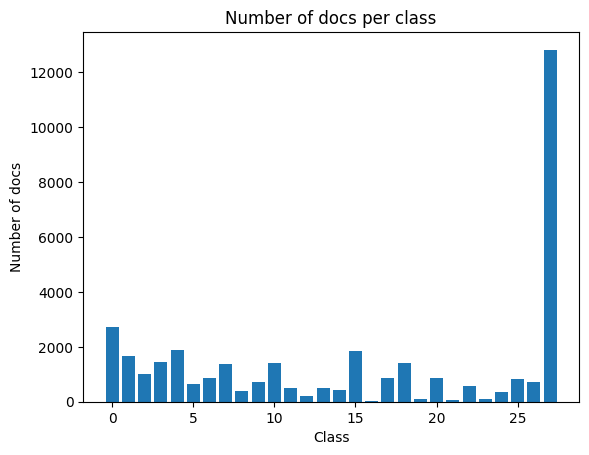

In [ ]:
plt.bar(range(28), counter)
plt.xlabel('Class')
plt.ylabel('Number of docs')
plt.title('Number of docs per class')
plt.show()

pre process the data

In [ ]:
# init the vectorizers
vectorizer = CountVectorizer()
vectorizer2 = CountVectorizer()

x_train_naive = vectorizer.fit_transform(x_train).toarray()
x_test_naive = vectorizer.transform(x_test).toarray()
x_val_naive = vectorizer.transform(x_val).toarray()

Naive Bayes Model Implimentation

In [ ]:
class NB():
  def __init__(self, alpha=1):
    self.alpha = alpha

  def fit(self, x, y):
    # N = num of documents, D = num words in dictionary
    N, D = x.shape

    # get the priors
    labels, pi = np.unique(y, return_counts=True)

    # get num labels
    C = len(labels)

    # now get the total word count for each class, and the individual word counts
    li = np.zeros((C, D))
    total_words = np.zeros(C)


    for c in tqdm(labels):
      # get all docs of class c
        x_c = x[y == c]

        # count all the words
        for doc in x_c:
          li[c] += doc
          total_words[c] += sum(i for i in doc if i != 0)


    # now divid the individual word counts by the total
    for c in tqdm(labels):
      li[c] = (li[c] + self.alpha) / (total_words[c] + self.alpha*D)

    # return the priors and the likelihoods
    self.pi = pi
    self.li = li
    return self

  def predict(self, x):
    pi = self.pi
    li = self.li

    predictions = []
    for doc in tqdm(x):

      pred = np.log(pi)

      for c in range(len(pred)):

        for d in range(len(doc)):
          if doc[d] != 0:
            pred[c] = pred[c] + (doc[d] * np.log(li[c][d]))

      predictions.append(np.argmax(pred))

    return predictions


eval accuracy method

In [ ]:
def eval_acc(y, yh):
  correct_count = 0
  for i in range(len(y)):
        if y[i] == yh[i]:
            correct_count += 1

  accuracy = correct_count / len(y) * 100
  return accuracy

init and train model



In [ ]:
model = NB()

model.fit(x_train_naive, y_train)

100%|██████████| 28/28 [00:00<00:00, 9633.38it/s]


test model on validation set

In [ ]:
yh = model.predict(x_val_naive)

100%|██████████| 4548/4548 [11:10<00:00,  6.78it/s]


test model on train set

In [ ]:
yh_train = model.predict(x_train_naive)

100%|██████████| 36308/36308 [1:28:44<00:00,  6.82it/s]


Evaluate the accuracy

In [ ]:
acc_train = eval_acc(y_train, yh_train)
acc_val = eval_acc(y_val, yh)

print(f'train accuracy: {acc_train:.4}')
print(f'validation accuracy: {acc_val:.4}')

train accuracy: 49.11
validation accuracy: 43.16


As can be seen above, the model does not seem to be performing very well. Next I will explore how accurate the model was on each category to see if that gives any further insights.

In [ ]:
def eval_acc_by_class(y, yh):
  correct_counts = np.zeros(28)
  total_counts = np.zeros(28)

  for i in range(len(y)):
        if y[i] == yh[i]:
            correct_counts[y[i]] += 1
        total_counts[y[i]] += 1

  accuracy = correct_counts / total_counts
  return accuracy

In [ ]:
acc_train_by_class = eval_acc_by_class(y_train, yh_train)
acc_val_by_class = eval_acc_by_class(y_val, yh)

In [ ]:
import matplotlib.pyplot as plt

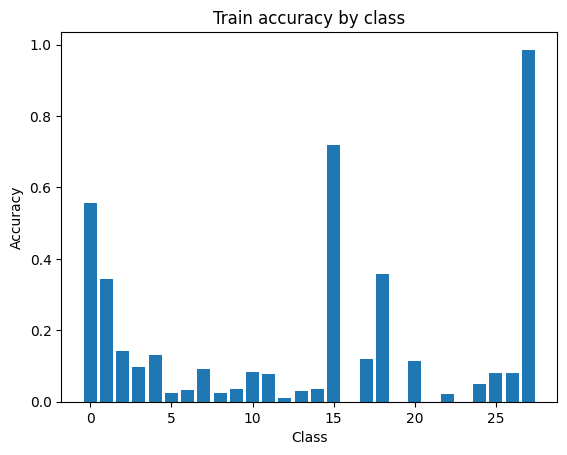

In [ ]:
plt.bar(range(len(acc_train_by_class)), acc_train_by_class)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Train accuracy by class')
plt.show()

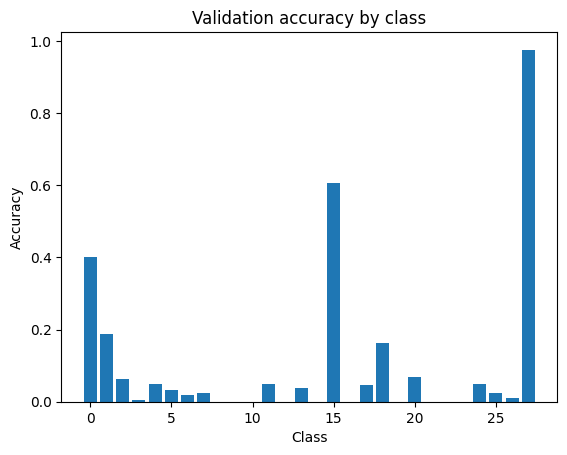

In [ ]:
plt.bar(range(len(acc_val_by_class)), acc_val_by_class)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Validation accuracy by class')
plt.show()

As can be seen, the model is very good at predicting class 27. This is because the train dataset is imbalenced, and there is a lot more documents with class 27 than any other class. Since this class is the neutral class, I beleive that it does not add much useful information so I will drop that class from the dataset and train the model again to see if there is an improvment.

drop all docs with class = 27

In [ ]:
x_train_filtered = [x_train[i] for i in range(len(y_train)) if y_train[i] != 27]
y_train_filtered = [label for label in y_train if label != 27]

In [ ]:
x_val_filtered = [x_val[i] for i in range(len(y_val)) if y_val[i] != 27]
y_val_filtered = [label for label in y_val if label != 27]

display the class distribution

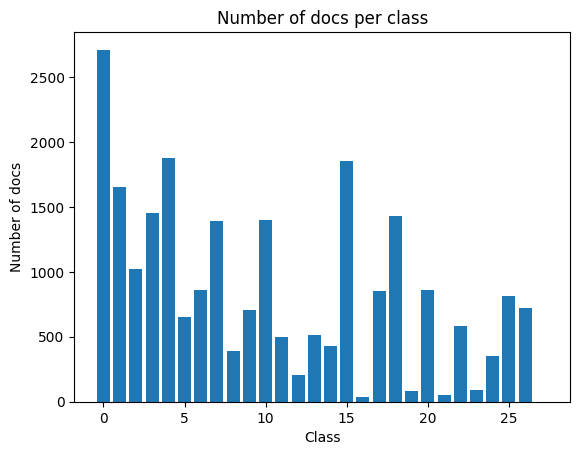

In [ ]:
counter = np.zeros(28)
for y in y_train_filtered:
  counter[y] +=1

plt.bar(range(28), counter)
plt.xlabel('Class')
plt.ylabel('Number of docs')
plt.title('Number of docs per class')
plt.show()

pre-process filtered data

In [ ]:
# init the vectorizers
vectorizer2 = CountVectorizer()

x_train_filtered_naive = vectorizer2.fit_transform(x_train_filtered).toarray()
x_val_filtered_naive = vectorizer2.transform(x_val_filtered).toarray()

train new model on filtered data

In [ ]:
model2 = NB()

model2.fit(x_train_filtered_naive, y_train_filtered)

100%|██████████| 27/27 [00:00<00:00, 8998.51it/s]


test model on validation set

In [ ]:
yh_val_filtered = model2.predict(x_val_filtered_naive)

100%|██████████| 2956/2956 [05:12<00:00,  9.45it/s]


test model on train set

In [ ]:
yh_train_filtered = model2.predict(x_train_filtered_naive)

100%|██████████| 23485/23485 [41:02<00:00,  9.54it/s]


display accuracy

In [ ]:
acc_train_filtered = eval_acc(y_train_filtered, yh_train_filtered)
acc_val_filtered = eval_acc(y_val_filtered, yh_val_filtered)
print(f'train accuracy: {acc_train_filtered:.4}')
print(f'validation accuracy: {acc_val_filtered:.4}')

train accuracy: 59.62
validation accuracy: 39.72


The accuracy still seems quite low. Again I will show the accuracy by class get a better understanding

In [ ]:
acc_train_by_class_filtered = eval_acc_by_class(y_train_filtered, yh_train_filtered)
acc_val_by_class_filtered = eval_acc_by_class(y_val_filtered, yh_val_filtered)

<ipython-input-18-6389719a1ba1>:10: RuntimeWarning: invalid value encountered in divide
  accuracy = correct_counts / total_counts


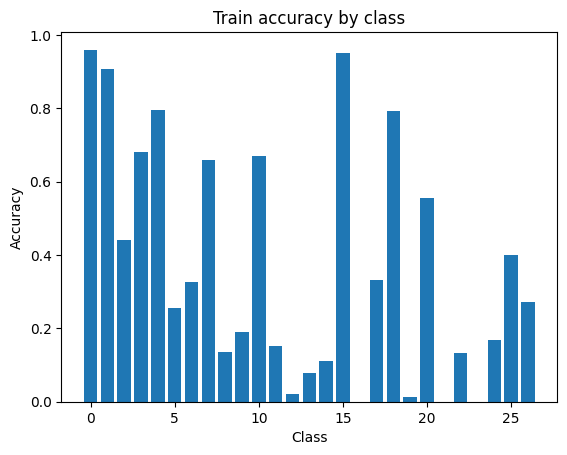

In [ ]:
plt.bar(range(len(acc_train_by_class_filtered)), acc_train_by_class_filtered)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Train accuracy by class')
plt.show()

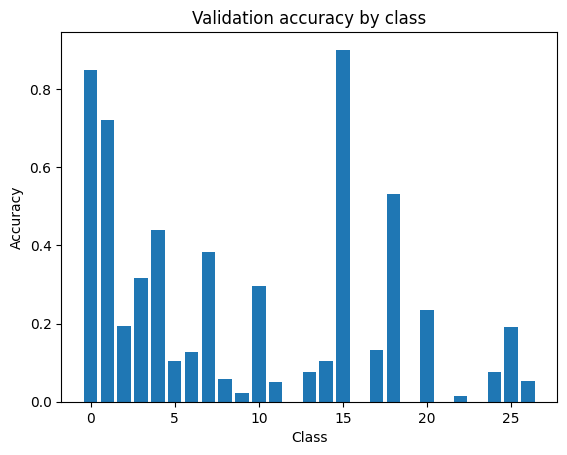

In [ ]:
plt.bar(range(len(acc_val_by_class_filtered)), acc_val_by_class_filtered)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Validation accuracy by class')
plt.show()

As can be seen above, the accuracy is still low, however it did improve for certain classes. Below I compare the accuracy by class from the initial dataset and the filtered data set

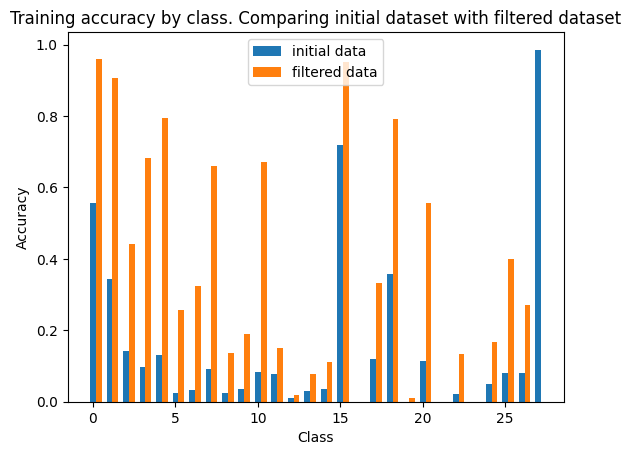

In [ ]:
plt.bar(np.arange(len(acc_train_by_class)), acc_train_by_class, width=0.35, label='initial data')

plt.bar(np.arange(len(acc_train_by_class_filtered))+0.35, acc_train_by_class_filtered, width=0.35, label='filtered data')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Training accuracy by class. Comparing initial dataset with filtered dataset')
plt.legend()
plt.show()

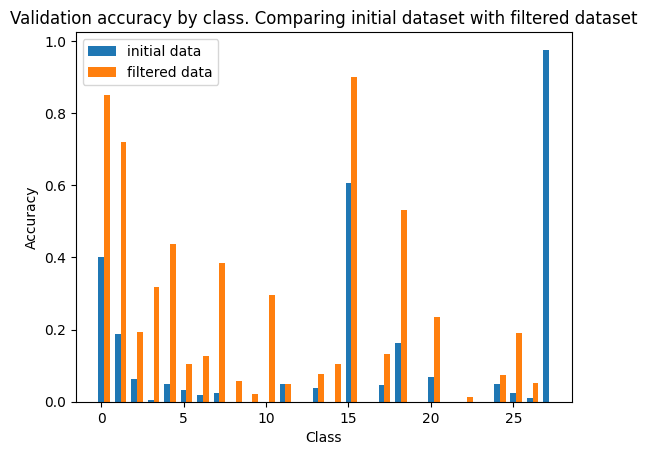

In [ ]:
plt.bar(np.arange(len(acc_val_by_class)), acc_val_by_class, width=0.35, label='initial data')

plt.bar(np.arange(len(acc_val_by_class_filtered))+0.35, acc_val_by_class_filtered, width=0.35, label='filtered data')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Validation accuracy by class. Comparing initial dataset with filtered dataset')
plt.legend()
plt.show()

As can be seen above, when the over-represented neutral category is removed, it allows the model to learn the other categories better, improving the accuracy for the other categories.

However, even in the filtered dataset, the data is not balenced. This leads to the model learning some classes a lot better than other classes.

To get the best performance with this type of model it is important to have a balenced dataset with equal representation for all classes.